## Background 

In this analysis, we attempt to answer the question of how many individuals are potentially eligible or impacted by Massachusetts expungement eligibility. 

In [1]:
import numpy as np
import pandas as pd
import math

from datetime import date
from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style="ticks")

## Data Source (Under 21 / Unarmed)

The data source for this comes from the Massachusetts State Police CrimeSOLV that contains 'crime data from police agencies in Massachusetts which report data to the Crime Reporting Unit in the format of the "National Incident Based Reporting System." The majority of police agencies now use this way of reporting their crime data.'

Unfortunately, there is no API for retrieving the data, but a report can be configureed and downloaded as a CSV at https://masscrime.chs.state.ma.us. Using the reporting system, 

<img src="../img/report_selection.png" width="400">

Columns are selected and arranged in the following manner:

<img src="../img/report_columns.png" width="800">

With the following filters:

<table>
  <tr>
      <td><img src="../img/select_age.png" width="400"></td>
      <td><img src="../img/select_offense.png" width="400"></td>
      <td><img src="../img/select_unarmed.png" width="400"></td>
    </tr>
</table>    

This report can then be downloaded in CSV list format for further analysis.

In [2]:
# Load data from downloaded CSV
arrests = pd.read_csv(
    "../data/arrests_by_age.csv", skiprows=5, 
    names=list(["Date","Offense","Armed","Age","Count","dummy"]), 
    index_col=False)

# Remove empty entries and drop dummy cols
arrests = arrests[arrests["Count"].notnull()] \
    .drop(["Armed","dummy"], axis=1) \
    .groupby(["Date", "Offense", "Age"]) \
    .agg("sum").reset_index()

arrests.Count = pd.to_numeric(arrests['Count'], errors='coerce')
arrests.head()

,Date,Offense,Age,Count
0,1991,Aggravated Assault,15,1.0
1,1991,All Other Larceny,14,1.0
2,1991,All Other Offenses,13,1.0
3,1991,Burglary/Breaking & Entering,10,1.0
4,1991,Burglary/Breaking & Entering,14,1.0


### Pre-processing (Categorize offenses, expungibility, etc)

In [3]:
# TODO: Read all of this from a metadata file
# Broad categories
crimes_against_person = list([
    "Murder and Nonnegligent Manslaughter",
    "Negligent Manslaughter",
    "Justifiable Homicide",
    "Kidnapping/Abduction",
    "Rape",
    "Sodomy",
    "Sexual Assault With An Object",
    "Fondling",
    "Incest",
    "Statutory Rape",
    "Aggravated Assault",
    "Simple Assault",
    "Intimidation",
    "Human Trafficking, Commercial Sex Acts",
    "Human Trafficking, Involuntary Servitude"])

crimes_against_property = list([
    "Arson",
    "Bribery",
    "Burglary/Breaking & Entering",
    "Counterfeiting/Forgery",
    "Destruction/Damage/Vandalism of Property",
    "Embezzlement",
    "Extortion/Blackmail",
    "False Pretenses/Swindle/Confidence Game",
    "Credit Card/Automatic Teller Fraud",
    "Impersonation",
    "Welfare Fraud",
    "Wire Fraud",
    "Identity Theft",
    "Hacking/Computer Invasion",
    "Robbery",
    "Pocket-picking",
    "Purse-snatching",
    "Shoplifting",
    "Theft From Building",
    "Theft From Coin Operated Machine or Device",
    "Theft From Motor Vehicle",
    "Theft of Motor Vehicle Parts/Accessories",
    "All Other Larceny",
    "Motor Vehicle Theft",
    "Stolen Property Offenses"
])

crimes_against_society = list([
    "Drug/Narcotic Violations",
    "Drug Equipment Violations",
    "Betting/Wagering",
    "Operating/Promoting/Assisting Gambling",
    "Gambling Equipment Violations",
    "Sports Tampering",
    "Pornography/Obscene Material",
    "Prostitution",
    "Assisting or Promoting Prostitution",
    "Purchasing Prostitution",
    "Weapon Law Violations",
    "Animal Cruelty"
])

group_b_offenses = list([
    "Bad Checks",
    "Curfew/Loitering/Vagrancy Violations",
    "Disorderly Conduct",
    "Driving Under the Influence",
    "Drunkenness",
    "Family Offenses (Nonviolent)",
    "Liquor Law Violations",
    "Peeping Tom",
    "Runaway",
    "Trespass of Real Property",
    "All Other Offenses"
])

missing = list(["Missing"])

categories = { i:"Crimes Against Person" for i in crimes_against_person }
categories.update({ i: "Crimes Against Property" for i in crimes_against_property})
categories.update({ i: "Crimes Against Society" for i in crimes_against_society})
categories.update({ i: "Group B Offenses" for i in group_b_offenses})
categories.update({ i: "Missing" for i in missing})

In [4]:
# Add offense category
arrests["Category"] = arrests["Offense"].replace(categories)

# Add label for disqualifying offenses
disqualifying_offenses = list([
    # Result / intent in Death or serious bodily injury
    'Murder and Nonnegligent Manslaughter',
    'Aggravated Assault',
    'Negligent Manslaughter',
    'Rape',
    'Sodomy',
    'Sexual Assault With An Object'
])
arrests["Disqualifying_Offense"] = arrests['Offense'].isin(disqualifying_offenses)

# Assign crime type - this is incorrect since all are assigned misdemeanor
crime_type = {offense: "misdemeanor" for offense in arrests["Offense"].unique()}
crime_type["Arson"] = "felony"
crime_type["Robbery"] = "felony"
arrests["Offense_Type"] = arrests["Offense"].map(crime_type)

In [5]:
# Expungement eligibility based on age, offense and offense type (felony/misdemeanor) and time cutoff
def eligible(row):
    if row["Age"] >= 21 or row["Disqualifying_Offense"]:
        return False
    cutoff = 7 if row["Offense_Type"] == 'felony' else 3
    current_year = date.today().year
    years_since = current_year - row["Date"]
    return years_since >= cutoff

arrests["Expungible"] = arrests.apply(eligible, axis=1)

In [6]:
# Unique offenses that are not disqualified according to the logic above
arrests[arrests["Disqualifying_Offense"] == False]["Offense"].unique()

array(['All Other Larceny', 'All Other Offenses',
       'Burglary/Breaking & Entering',
       'Destruction/Damage/Vandalism of Property', 'Disorderly Conduct',
       'Driving Under the Influence', 'Drug/Narcotic Violations',
       'Liquor Law Violations', 'Motor Vehicle Theft', 'Simple Assault',
       'Theft From Building', 'Theft From Motor Vehicle',
       'Trespass of Real Property', 'Arson', 'Counterfeiting/Forgery',
       'Drunkenness', 'False Pretenses/Swindle/Confidence Game',
       'Family Offenses (Nonviolent)', 'Intimidation', 'Robbery',
       'Runaway', 'Shoplifting', 'Stolen Property Offenses',
       'Theft of Motor Vehicle Parts/Accessories',
       'Weapon Law Violations', 'Credit Card/Automatic Teller Fraud',
       'Drug Equipment Violations', 'Fondling', 'Kidnapping/Abduction',
       'Prostitution', 'Purse-snatching', 'Bad Checks',
       'Curfew/Loitering/Vagrancy Violations', 'Embezzlement',
       'Impersonation', 'Statutory Rape',
       'Theft From Coin 

In [7]:
arrests.head()

,Date,Offense,Age,Count,Category,Disqualifying_Offense,Offense_Type,Expungible
0,1991,Aggravated Assault,15,1.0,Crimes Against Person,True,misdemeanor,False
1,1991,All Other Larceny,14,1.0,Crimes Against Property,False,misdemeanor,True
2,1991,All Other Offenses,13,1.0,Group B Offenses,False,misdemeanor,True
3,1991,Burglary/Breaking & Entering,10,1.0,Crimes Against Property,False,misdemeanor,True
4,1991,Burglary/Breaking & Entering,14,1.0,Crimes Against Property,False,misdemeanor,True


In [8]:
# Write this dataframe back to disk for other visualizations
arrests.to_csv("../output/arrest_expungibility.csv", index=False)

## Basic Stats

In [9]:
arrests[arrests["Expungible"]]["Count"].sum()

461069.0

In [10]:
crime_count = arrests[arrests["Expungible"]][["Offense", "Count"]] \
    .groupby(["Offense"]) \
    .sum() \
    .sort_values("Count", ascending=False) \
    .reset_index()

In [11]:
crime_count

,Offense,Count
0,All Other Offenses,73370.0
1,Liquor Law Violations,53953.0
2,Simple Assault,53705.0
3,Drug/Narcotic Violations,52534.0
4,Shoplifting,36009.0
5,Disorderly Conduct,34588.0
6,Destruction/Damage/Vandalism of Property,21962.0
7,Drunkenness,18649.0
8,Burglary/Breaking & Entering,18358.0
9,Trespass of Real Property,16113.0


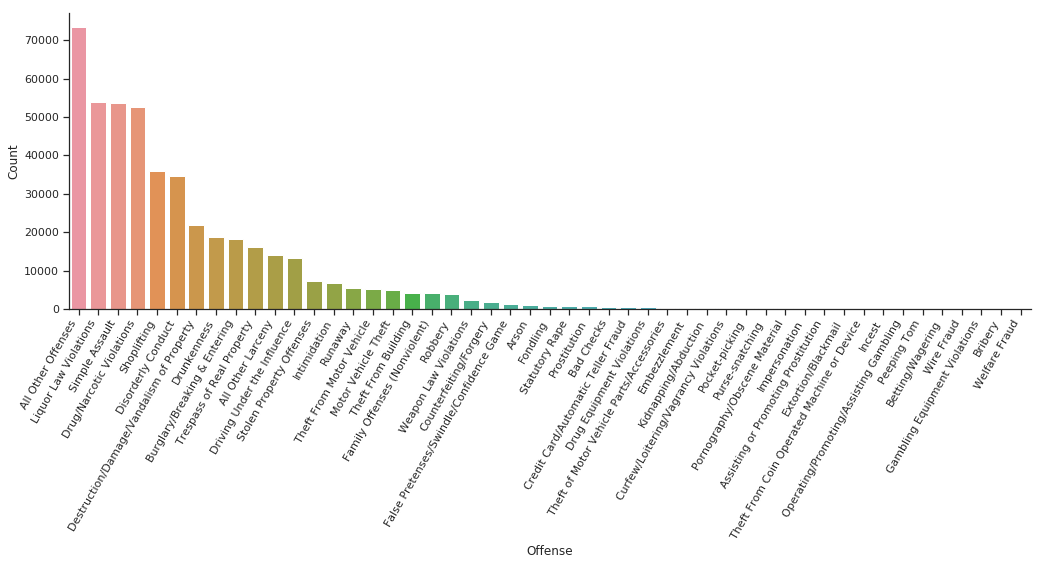

In [12]:
g = sns.catplot(
    x="Offense", y="Count", kind="bar", 
    data=crime_count, 
    height=5, aspect=3)
g.set_xticklabels(rotation=60, ha="right");

## Visualizations

In [13]:
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]    
  
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)

def crime_plot(categories):
    plt.figure(figsize=(12, 6))
    ax = plt.subplot(111)    
    ax.spines["top"].set_visible(False)    
    ax.spines["bottom"].set_visible(False)    
    ax.spines["right"].set_visible(False)    
    ax.spines["left"].set_visible(False)    
    ax.get_xaxis().tick_bottom()    
    ax.get_yaxis().tick_left()    
    plt.xticks(fontsize=10)    
    plt.tick_params(axis="both", which="both", bottom=False, top=False,    
                    labelbottom=True, left=False, right=False, labelleft=True)    

    for rank, column in enumerate(categories):  
        if column in plot_data.columns:
            plt.plot(plot_data["Date"].values, plot_data[column].values, lw=2.5, color=tableau20[rank%20])   
            y_pos = plot_data[column].values[-1] - 0.5   
            plt.text(2016.5, y_pos, column, fontsize=11, color=tableau20[rank%20]) 
    return plt

In [14]:
plot_data = arrests[arrests["Expungible"]] \
    .drop(["Expungible", "Age"], axis=1) \
    .groupby(["Category","Date", "Offense"]) \
    .sum() \
    .pivot_table(values="Count", index="Date", columns="Offense", fill_value=0) \
    .reset_index()

### Crimes Against Person

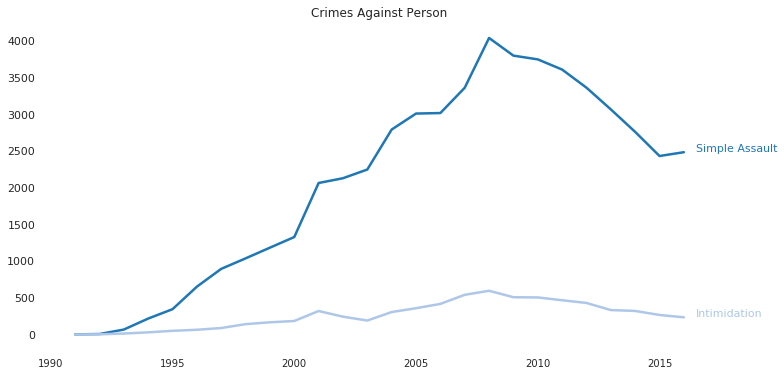

In [15]:
outliers = ["Simple Assault", "Intimidation"]
plt = crime_plot(outliers)
plt.title("Crimes Against Person")
plt.show();

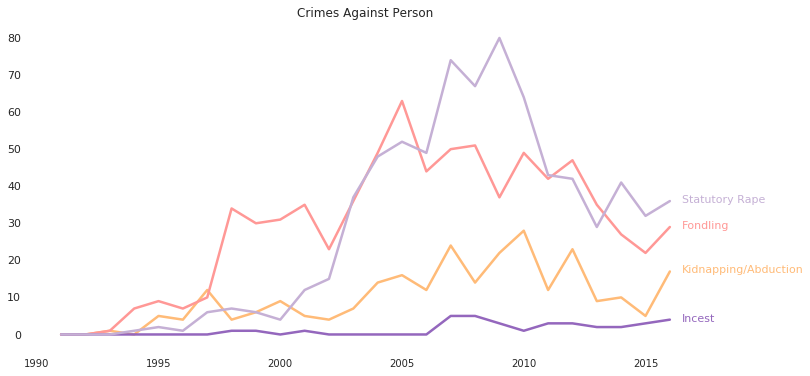

In [16]:
plt = crime_plot([i for i in crimes_against_person if i not in outliers])
plt.title("Crimes Against Person")
plt.show();

### Crimes Against Property

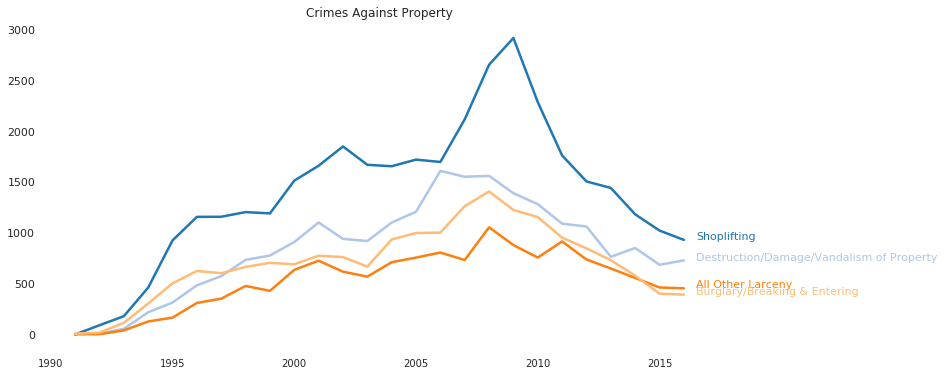

In [17]:
outliers = ["Shoplifting", "Destruction/Damage/Vandalism of Property", 
            "All Other Larceny", "Burglary/Breaking & Entering"]
plt = crime_plot(outliers)
plt.title("Crimes Against Property")
plt.show();

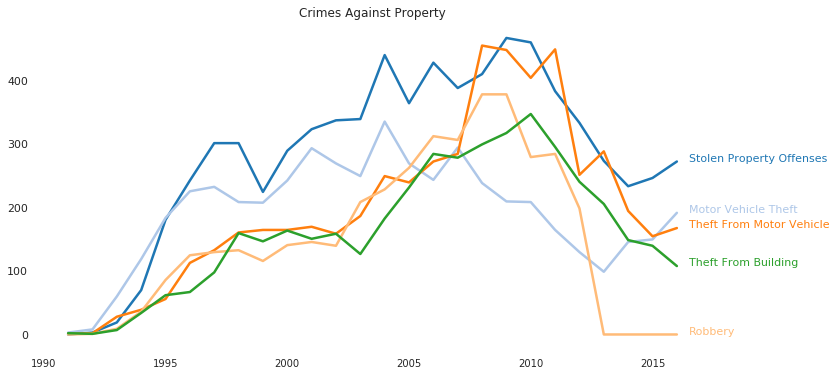

In [18]:
midliers = ["Stolen Property Offenses", "Motor Vehicle Theft", 
            "Theft From Motor Vehicle", "Robbery", "Theft From Building"]
plt = crime_plot(midliers)
plt.title("Crimes Against Property")
plt.show();

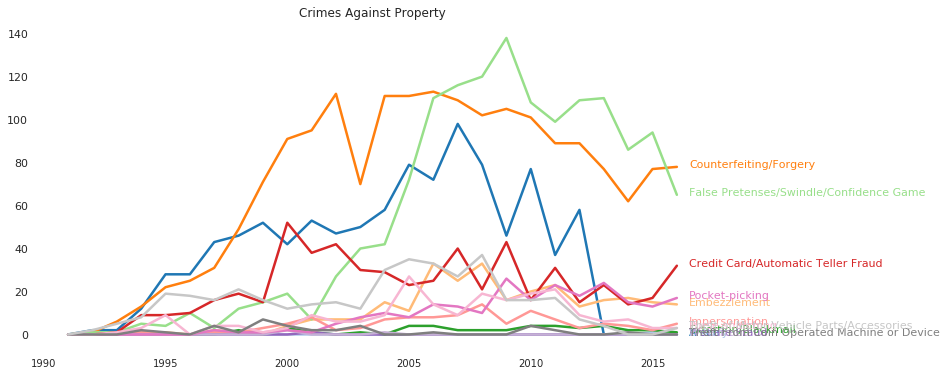

In [19]:
plt = crime_plot([i for i in crimes_against_property if i not in outliers + midliers])
plt.title("Crimes Against Property")
plt.show();

### Crimes Against Society

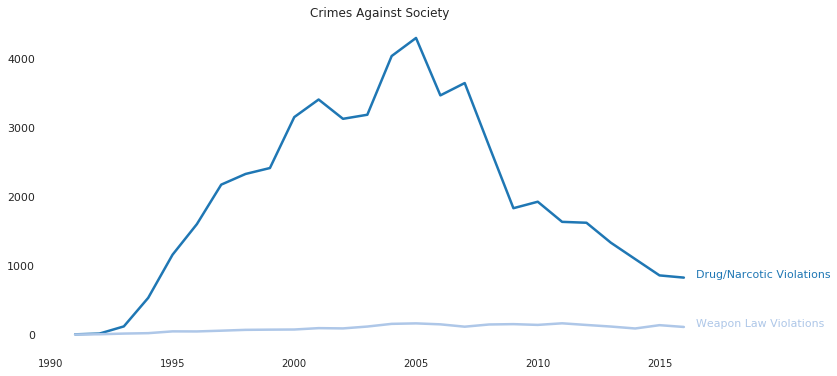

In [20]:
outliers = ["Drug/Narcotic Violations", "Weapon Law Violations"]
plt = crime_plot(outliers)
plt.title("Crimes Against Society")
plt.show();

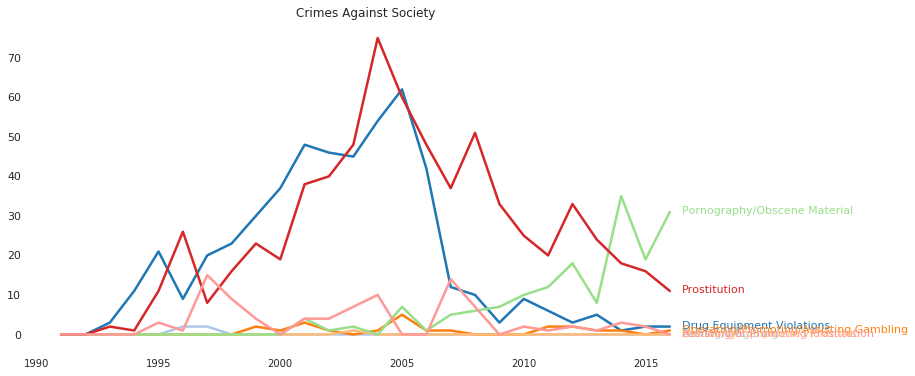

In [21]:
plt = crime_plot([i for i in crimes_against_society if i not in outliers])
plt.title("Crimes Against Society")
plt.show();

### Group B Offenses

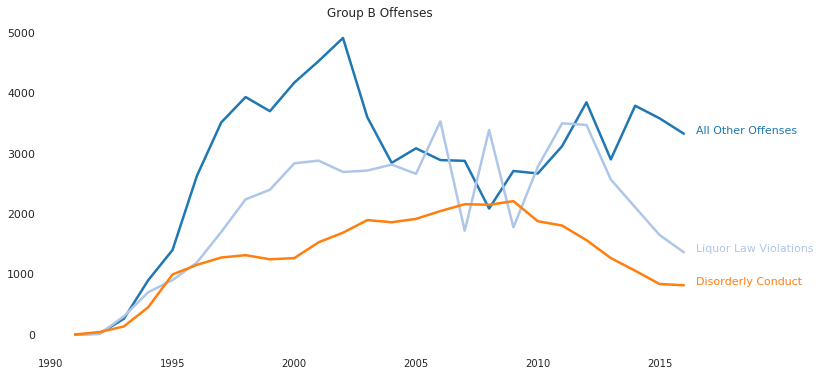

In [22]:
outliers = ["All Other Offenses", "Liquor Law Violations", "Disorderly Conduct"]
plt = crime_plot(outliers)
plt.title("Group B Offenses")
plt.show();

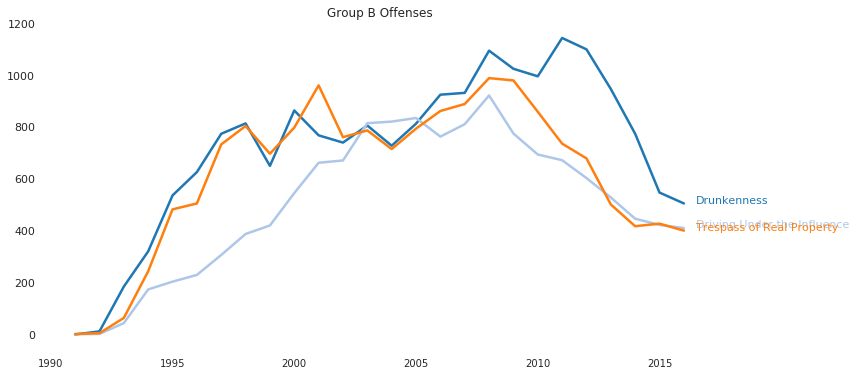

In [23]:
midliers = ["Drunkenness", "Driving Under the Influence", 
            "Trespass of Real Property"]
plt = crime_plot(midliers)
plt.title("Group B Offenses")
plt.show();

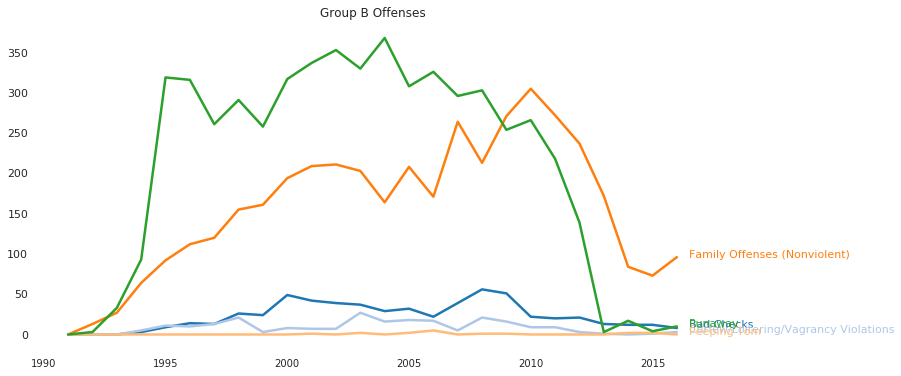

In [24]:
plt = crime_plot([i for i in group_b_offenses if i not in outliers + midliers])
plt.title("Group B Offenses")
plt.show();